Imports 

In [42]:
import geopandas as gp
import pandas as pd
import xarray as xr
import rioxarray
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sb
import sys
from importlib import reload
from hyspexutil.features import bandutil459 as bu


### 

In [7]:
HySpexPth = Path("/Volumes/FIREICE/fihyper/cwaigl/")
subpath = "03_products/cropped_masked_final/"
filepatt = "VNIR_SWIR_rad_geo_atm_bcor_crop.bsq"

In [8]:
fieldpath = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/Field_Data") 
hex20 = "CW_hex20_BC_merged.gpkg"

In [9]:
hex20_df = gp.read_file(fieldpath / hex20)

In [10]:
hex20_df

,id,left,top,right,bottom,vegclass,flighline,fileprefix,layer,path,geometry
0,97562,437147.056349,7.182904e+06,437170.150360,7.182884e+06,Bare Ground,04,20200830-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((437268.300 7176543.741, 437274..."
1,8506,433509.749653,7.174824e+06,433532.843664,7.174804e+06,Closed Black/White Spruce Forest,01,20200830-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((433532.844 7174813.741, 433527..."
2,31053,434427.736581,7.175454e+06,434450.830592,7.175434e+06,Closed Tall Alder,01,20200830-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((434416.190 7175443.741, 434410..."
3,43399,434930.031316,7.175604e+06,434953.125326,7.175584e+06,Closed Spruce/Paper Birch/Aspen Forest,02,20200830-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((434935.805 7175603.741, 434930..."
4,129823,438446.094455,7.176694e+06,438469.188466,7.176674e+06,Black Spruce Woodland with Tussocks,05,20200830-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((438376.812 7176623.741, 438382..."
...,...,...,...,...,...,...,...,...,...,...,...
65,43399,434930.031316,7.175604e+06,434953.125326,7.175584e+06,Closed Spruce/Paper Birch/Aspen Forest,07,20210803-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((434935.805 7175603.741, 434930..."
66,123860,438203.607342,7.176674e+06,438226.701353,7.176654e+06,Open Black Spruce Forest,01,20210803-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((438244.022 7176653.741, 438238..."
67,109839,437632.030575,7.175924e+06,437655.124586,7.175904e+06,Wet Sedge Meadow,02,20210803-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((437447.278 7175813.741, 437441..."
68,57863,435518.928590,7.176004e+06,435542.022601,7.175984e+06,Closed Paper Birch Forest,06,20210803-BC,Dissolved,"MultiPolygon?crs=EPSG:32606&field=fid:long(0,0...","MULTIPOLYGON (((435553.570 7175993.741, 435559..."


In [6]:
hex20_df.groupby(by=['fileprefix', 'vegclass'])['vegclass'] .count()

fileprefix   vegclass                                
20200830-BC  Bare Ground                                 1
             Black Spruce Woodland with Tussocks         1
             Black Spruce/Tamarack Forest                1
             Closed Black Spruce Forest                  2
             Closed Black/White Spruce Forest            1
             Closed Paper Birch Forest                   3
             Closed Quaking Aspen Forest                 2
             Closed Quaking Aspen/White Spruce Forest    1
             Closed Spruce/Paper Birch Forest            2
             Closed Spruce/Paper Birch/Aspen Forest      1
             Closed Tall Alder                           2
             Closed Tall Birch/Willow Shrub              1
             Closed White Spruce Forest                  1
             Open Black Spruce Forest                    4
             Open Quaking Aspen/Spruce Forest            1
             Open Spruce/Paper Birch Forest              2
  

In [24]:
selected_band_idx = bu.mlbands_idx
selected_bands = bu.mlbands

In [27]:
def get_datafile(row, smooth=True):
    fpth = HySpexPth / f"{row.fileprefix.replace('-', '_')}" / subpath / f"{row.fileprefix}_{row.flightline}_{filepatt}"
    return fpth

def get_singlefilesampledf(labelrow, sampledf=None):
    return sampledf[(sampledf.fileprefix==labelrow.fileprefix) & (sampledf.flightline==labelrow.flightline)]

def get_dataset(fpth):
    testdata = xr.open_dataset(fpth, engine="rasterio")
    testdata.attrs['long_name'] = "spectral reflectance, %*100"
    testdata.attrs['name'] = "spectral reflectance, %*100"
    testdata['band_data'].attrs['long_name']  =  "spectral reflectance, %*100"
    return testdata

def get_spectra_fromsingle(samplerow, dataset='dummy'):
    pt = samplerow.geometry
    spectrum = dataset.band_data.sel(x=pt.x, y=pt.y, method='nearest').values[:-10]
    return spectrum

def get_spectra(labelrow, sampledf=None):
    results = []
    subsubsample = get_singlefilesampledf(labelrow, sampledf)
    fn = get_datafile(labelrow)
    print(f"working on {fn}")
    testdata = get_dataset(fn)
    print("Got dataset opened") 
    for idx, row in subsubsample.iterrows():
        print(f"   working on {idx}, {row.species} at {row.geometry}") 
        spectrum = get_spectra_fromsingle(row, dataset=testdata)
        dictitem = {
            'fid': idx,
            'species': row.species,
            'event': row.fileprefix,
            'flightline': row.flightline,
            'vegclass': row.vegclass,
            'context': row.context,
            'spectrum': spectrum,
            }
        results.append(dictitem)
    testdata.close()
    return results
    

In [11]:
vegpath = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/GIS/veg_locations/") 
hex20_BC_2020 = "CW_20200830_hex_labeled.gpkg"

In [12]:
hex20_df = gp.read_file(vegpath / hex20_BC_2020)
hex20_df.rename(columns={'flighline': 'flightline'}, inplace=True)
hex20_df['fileprefix'] = '20200830-BC'
hex20_df

,id,left,top,right,bottom,vegclass,flightline,geometry,fileprefix
0,140522,438879.107157,7.175704e+06,438902.201168,7.175684e+06,Wetlands,06,"POLYGON ((438879.107 7175693.741, 438884.881 7...",20200830-BC
1,140524,438879.107157,7.175664e+06,438902.201168,7.175644e+06,Wetlands,06,"POLYGON ((438879.107 7175653.741, 438884.881 7...",20200830-BC
2,140098,438861.786649,7.175674e+06,438884.880660,7.175654e+06,Wetlands,06,"POLYGON ((438861.787 7175663.741, 438867.560 7...",20200830-BC
3,140523,438879.107157,7.175684e+06,438902.201168,7.175664e+06,Wetlands,06,"POLYGON ((438879.107 7175673.741, 438884.881 7...",20200830-BC
4,136258,438705.902076,7.175784e+06,438728.996087,7.175764e+06,Open Spruce/Paper Birch Forest,06,"POLYGON ((438705.902 7175773.741, 438711.676 7...",20200830-BC
...,...,...,...,...,...,...,...,...,...
130,139293,438827.145633,7.174734e+06,438850.239643,7.174714e+06,Water,06,"POLYGON ((438827.146 7174723.741, 438832.919 7...",20200830-BC
131,138421,438792.504617,7.175134e+06,438815.598627,7.175114e+06,Water,06,"POLYGON ((438792.505 7175123.741, 438798.278 7...",20200830-BC
132,139718,438844.466141,7.174744e+06,438867.560152,7.174724e+06,Water,06,"POLYGON ((438844.466 7174733.741, 438850.240 7...",20200830-BC
133,142210,438948.389189,7.176024e+06,438971.483200,7.176004e+06,Water,06,"POLYGON ((438948.389 7176013.741, 438954.163 7...",20200830-BC


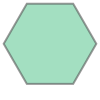

In [20]:
hex20_df.iloc[0].geometry

In [25]:
hex20_df.flightline.unique()
labeldf = hex20_df[['fileprefix', 'flightline']].drop_duplicates()
labeldf

,fileprefix,flightline
0,20200830-BC,06
11,20200830-BC,05
40,20200830-BC,04
79,20200830-BC,03
100,20200830-BC,02
115,20200830-BC,01


In [31]:
samples = []
for _, labelrow in labeldf.iterrows():
    subsubsample = get_singlefilesampledf(labelrow, hex20_df)
    fn = get_datafile(labelrow)
    print(f"working on {fn}")

working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_06_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_05_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_02_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_01_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq


In [47]:
row = subsubsample.iloc[0]
xs = np.arange(np.floor(row.left), np.ceil(row.right))
ys = np.arange(np.floor(row.bottom), np.ceil(row.top))
pts = [Point(x, y) for x in xs for y in ys if row.geometry.contains(Point(x, y))]
xs = xr.DataArray([pt.x for pt in pts], dims='z')
ys = xr.DataArray([pt.y for pt in pts], dims='z')

In [49]:
testfile = "/Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_01_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq"
testDS = xr.open_dataset(testfile, engine="rasterio", chunks={'band': 1, 'x': 200, 'y': 400})

testDF_full = testDS.band_data.sel(x=xs, y=ys, band=selected_bands[:-10], method="nearest").to_dataframe().reset_index().pivot(
    index=['x', 'y'], columns=['band'], values='band_data').reset_index()
testDF = testDF_full.drop(columns=['x', 'y'])
testDF.columns = [f"band_{str(item).zfill(3)}" for item in testDF.columns]
testDF = testDF.where(testDF < 10000, 0.0)



In [53]:
testDF.mean().values

array([   8.21839 ,   35.652298,   50.936783,   75.40804 ,  156.11781 ,
        203.06322 ,  220.16667 ,  229.90805 ,  221.13792 ,  247.81322 ,
        703.45404 ,  714.18964 , 1031.6322  , 1401.0287  , 1368.4885  ,
       1493.3506  , 1488.1523  , 1425.9656  ,  713.95404 ,  732.9569  ,
        910.6638  ,  867.11206 ,  852.87354 ,  842.7098  ,  797.2902  ,
        359.61493 ,  427.69827 ,  433.7069  ,  483.79022 ,  431.15518 ],
      dtype=float32)

In [61]:
labeldf = hex20_df[['fileprefix', 'flightline']].drop_duplicates()
samples = []
for _, labelrow in labeldf.iterrows():
    subsubsample = get_singlefilesampledf(labelrow, hex20_df)
    fn = get_datafile(labelrow)
    print(f"working on {fn}")
    with xr.open_dataset(fn, engine="rasterio", chunks={'band': 1, 'x': 200, 'y': 400}) as testDS:
        for idx, row in subsubsample.iterrows():
            xs = np.arange(np.floor(row.left), np.ceil(row.right))
            ys = np.arange(np.floor(row.bottom), np.ceil(row.top))
            pts = [Point(x, y) for x in xs for y in ys if row.geometry.contains(Point(x, y))]
            xs = xr.DataArray([pt.x for pt in pts], dims='z')
            ys = xr.DataArray([pt.y for pt in pts], dims='z')
            testDF_full = testDS.band_data.sel(x=xs, y=ys, band=selected_bands[:-10], method="nearest").to_dataframe().reset_index().pivot(
            index=['x', 'y'], columns=['band'], values='band_data').reset_index()
            testDF = testDF_full.drop(columns=['x', 'y'])
            testDF.columns = [f"band_{str(item).zfill(3)}" for item in testDF.columns]
            testDF = testDF.where(testDF < 10000, 0.0)
            dictelem = {
                'label': row.vegclass,
                'data_means': testDF.mean().values,
                'data_stds': testDF.std().values
            }
            samples.append(dictelem)

samples
                                     


working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_06_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_05_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_02_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
working on /Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_01_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq


[{'label': 'Wetlands',
  'data_means': array([   8.21839 ,   35.652298,   50.936783,   75.40804 ,  156.11781 ,
          203.06322 ,  220.16667 ,  229.90805 ,  221.13792 ,  247.81322 ,
          703.45404 ,  714.18964 , 1031.6322  , 1401.0287  , 1368.4885  ,
         1493.3506  , 1488.1523  , 1425.9656  ,  713.95404 ,  732.9569  ,
          910.6638  ,  867.11206 ,  852.87354 ,  842.7098  ,  797.2902  ,
          359.61493 ,  427.69827 ,  433.7069  ,  483.79022 ,  431.15518 ],
        dtype=float32),
  'data_stds': array([ 13.056453,  17.66702 ,  13.282411,  11.456728,  19.65335 ,
          24.032316,  21.776463,  21.85801 ,  19.951197,  22.368471,
          86.2703  ,  89.67181 , 148.48642 , 224.76443 , 211.10779 ,
         230.97433 , 227.89343 , 215.1306  ,  84.747116,  91.02638 ,
         119.20541 , 109.71998 , 110.05271 , 105.71791 , 101.85579 ,
          50.678963,  65.65387 ,  54.11781 ,  93.82497 ,  84.3419  ],
        dtype=float32)},
 {'label': 'Wetlands',
  'data_means': ar

In [62]:
columns_mean = [f"mean_{ii}" for ii in testDF.columns] 
columns_std = [f"std_{ii}" for ii in testDF.columns] 

In [63]:
X = pd.concat([pd.DataFrame(columns=columns_mean,
             data=[item['data_means'] for item in samples]), 
               pd.DataFrame(columns=columns_std,
             data=[item['data_stds'] for item in samples])], axis=1)
X

,mean_band_006,mean_band_010,mean_band_020,mean_band_027,mean_band_040,mean_band_048,mean_band_062,mean_band_071,mean_band_084,mean_band_088,...,std_band_304,std_band_314,std_band_315,std_band_319,std_band_323,std_band_364,std_band_370,std_band_371,std_band_413,std_band_417
0,8.218390,35.652298,50.936783,75.408043,156.117813,203.063217,220.166672,229.908051,221.137924,247.813217,...,119.205406,109.719978,110.052711,105.717911,101.855789,50.678963,65.653870,54.117809,93.824966,84.341904
1,14.563218,48.994251,68.126434,97.143677,208.681030,267.669525,284.531616,297.945404,292.727020,328.112061,...,121.415993,115.378799,116.491226,115.943184,112.219666,64.463882,77.661598,76.940010,101.096466,93.777336
2,11.797688,41.390175,54.491329,79.271675,179.008667,227.849716,231.390167,237.612717,230.939301,259.777466,...,370.315887,360.140564,352.839264,354.507690,337.741394,182.616318,202.423416,213.817764,238.753784,219.443176
3,11.451149,39.514366,55.103447,81.672417,172.451157,222.885056,240.689651,252.209763,248.683914,280.724152,...,103.975914,100.485237,97.856667,102.613197,96.957291,65.061523,64.609222,69.646805,109.243912,94.022202
4,16.194202,52.420288,66.565216,90.811592,246.234787,311.327545,304.666656,309.089844,258.002899,297.008698,...,224.623230,208.719696,203.978012,212.403839,203.781494,122.980370,129.417496,133.424377,142.534760,138.245819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,29.182610,58.860870,74.365219,94.321739,221.608688,259.159424,210.110138,196.991302,155.463776,182.353622,...,234.598648,215.671555,217.128296,217.573807,210.999954,117.038399,128.766068,120.542557,153.320984,147.390121
131,8.936600,37.890491,46.069164,63.948128,161.227661,191.706055,157.976944,148.458206,121.605186,142.804031,...,208.900391,194.944733,198.327408,193.281555,183.191696,69.156349,99.378433,94.065140,161.229004,151.245285
132,60.982658,93.936417,94.679192,110.210983,243.228317,288.439301,239.260117,220.213867,171.494217,198.086700,...,268.625336,253.620544,251.145966,248.872696,243.324326,111.373154,137.914337,140.894943,187.277771,154.744339
133,75.365997,110.204613,112.204613,128.550430,262.812683,308.642639,257.262238,239.939484,190.648422,217.097977,...,329.116364,305.769318,297.999878,303.145447,288.021759,122.680527,125.418472,147.062805,170.798172,175.103745


In [64]:
outdir = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted/")
pd.DataFrame.from_records(samples).to_pickle(outdir / "20200830-BC_trainingpolyspectra.pkl.gz", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [65]:
y = pd.DataFrame(columns=['label'], data=[item['label'] for item in samples])
y

,label
0,Wetlands
1,Wetlands
2,Wetlands
3,Wetlands
4,Open Spruce/Paper Birch Forest
...,...
130,Closed Black/White Spruce Forest
131,Closed Black/White Spruce Forest
132,Closed Tall Alder
133,Closed Tall Alder


In [66]:
pd.concat([y, X], axis=1).to_pickle(outdir / "20200830-BC_trainingpolyspectradf.pkl.gz", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [67]:
print(X.shape, y.shape)

(135, 60) (135, 1)


---

In [190]:
datadir = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted/")
labeleddf = pd.read_pickle(datadir / "20200830-BC_trainingpolyspectradf.pkl.gz")

In [75]:
X = X.fillna(0)

In [68]:
y.value_counts().sort_index()

label                                   
Bare Ground                                  5
Black Spruce Woodland with Tussocks          6
Black Spruce/Tamarack Forest                11
Closed Black Spruce Forest                   6
Closed Black/White Spruce Forest             4
Closed Paper Birch Forest                    9
Closed Quaking Aspen Forest                  6
Closed Quaking Aspen/White Spruce Forest     6
Closed Spruce/Paper Birch Forest             9
Closed Spruce/Paper Birch/Aspen Forest       3
Closed Tall Alder                            6
Closed Tall Birch/Willow Shrub               3
Closed White Spruce Forest                   3
Open Black Spruce Forest                    15
Open Quaking Aspen/Spruce Forest             3
Open Spruce/Paper Birch Forest               6
Open Tall Alder Shrub                        6
Open Tall Birch Shrub                        3
Open White Spruce Forest                     6
Water                                        5
Wet Sedge Meadow   

In [93]:
new_y = y.replace(
    "Open Quaking Aspen/Spruce Forest", "Open Mixed Forest").replace(
    "Open Spruce/Paper Birch Forest", "Open Mixed Forest").replace(
    "Closed White Spruce Forest", "Closed Spruce Forest").replace(
    "Closed Black Spruce Forest", "Closed Spruce Forest").replace(
    "Closed Black/White Spruce Forest", "Closed Spruce Forest").replace(
    "Closed Spruce/Paper Birch Forest", "Closed Spruce/Paper Birch/Aspen Forest").replace(
#    "Closed Tall Alder", "Closed Tall Deciduous Shrub").replace(
#    "Closed Tall Birch/Willow Shrub", "Closed Tall Deciduous Shrub"
)

In [94]:
new_y.value_counts().sort_index()

label                                   
Bare Ground                                  5
Black Spruce Woodland with Tussocks          6
Black Spruce/Tamarack Forest                11
Closed Paper Birch Forest                    9
Closed Quaking Aspen Forest                  6
Closed Quaking Aspen/White Spruce Forest     6
Closed Spruce Forest                        13
Closed Spruce/Paper Birch/Aspen Forest      12
Closed Tall Alder                            6
Closed Tall Birch/Willow Shrub               3
Open Black Spruce Forest                    15
Open Mixed Forest                            9
Open Tall Alder Shrub                        6
Open Tall Birch Shrub                        3
Open White Spruce Forest                     6
Water                                        5
Wet Sedge Meadow                             7
Wetlands                                     7
dtype: int64

In [71]:
import sklearn
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE, ADASYN

In [72]:
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

In [76]:
n_scores = cross_val_score(model, X, new_y.values, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christine/miniconda3/envs/pyth

Accuracy: 0.615 (0.080)


/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [80]:
param_grid = {
                 'n_estimators': [100, 500],
                 'max_depth': [2, 5, 7, 9]
             }


In [81]:
grid_clf = RandomizedSearchCV(model, param_grid, cv=10)
grid_clf.fit(X, new_y.values)

/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 5, 7, 9],
                                        'n_estimators': [100, 500]})

In [83]:
grid_clf.best_params_

{'n_estimators': 100, 'max_depth': 9}

In [84]:
grid_clf.best_score_

0.6434065934065935

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, new_y, test_size=0.3, random_state=42)
#X_resampled, y_resampled = ADASYN(n_neighbors=1).fit_resample(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, max_depth=9)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
#print(y_test)

/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_32523/3955286908.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [96]:
print(sklearn.metrics.f1_score(y_test,y_predict, average='micro'))
print(sklearn.metrics.classification_report(y_test,y_predict))

0.6341463414634146
                                          precision    recall  f1-score   support

     Black Spruce Woodland with Tussocks       1.00      1.00      1.00         2
            Black Spruce/Tamarack Forest       0.56      1.00      0.71         5
               Closed Paper Birch Forest       1.00      1.00      1.00         2
             Closed Quaking Aspen Forest       0.67      1.00      0.80         2
Closed Quaking Aspen/White Spruce Forest       0.00      0.00      0.00         2
                    Closed Spruce Forest       0.00      0.00      0.00         2
  Closed Spruce/Paper Birch/Aspen Forest       0.50      0.67      0.57         3
                       Closed Tall Alder       1.00      0.33      0.50         3
          Closed Tall Birch/Willow Shrub       0.00      0.00      0.00         1
                Open Black Spruce Forest       0.83      1.00      0.91         5
                       Open Mixed Forest       1.00      0.25      0.40       

/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [91]:
cm = confusion_matrix(y_test, y_predict, )
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_predict, display_labels=sorted(y_test.unique()), xticks_rotation='vertical', normalize='true')

AttributeError: 'DataFrame' object has no attribute 'unique'

In [86]:
len(model.classes_)

19

In [87]:
y_test.value_counts().sort_index()

label                                   
Black Spruce Woodland with Tussocks         2
Black Spruce/Tamarack Forest                5
Closed Black Spruce Forest                  1
Closed Paper Birch Forest                   2
Closed Quaking Aspen Forest                 2
Closed Quaking Aspen/White Spruce Forest    2
Closed Spruce Forest                        1
Closed Spruce/Paper Birch/Aspen Forest      3
Closed Tall Alder                           3
Closed Tall Birch/Willow Shrub              1
Open Black Spruce Forest                    5
Open Mixed Forest                           4
Open Tall Alder Shrub                       2
Open White Spruce Forest                    1
Water                                       3
Wet Sedge Meadow                            2
Wetlands                                    2
dtype: int64

In [88]:
y_train.value_counts().sort_index()

label                                   
Bare Ground                                  5
Black Spruce Woodland with Tussocks          4
Black Spruce/Tamarack Forest                 6
Closed Black Spruce Forest                   5
Closed Paper Birch Forest                    7
Closed Quaking Aspen Forest                  4
Closed Quaking Aspen/White Spruce Forest     4
Closed Spruce Forest                         6
Closed Spruce/Paper Birch/Aspen Forest       9
Closed Tall Alder                            3
Closed Tall Birch/Willow Shrub               2
Open Black Spruce Forest                    10
Open Mixed Forest                            5
Open Tall Alder Shrub                        4
Open Tall Birch Shrub                        3
Open White Spruce Forest                     5
Water                                        2
Wet Sedge Meadow                             5
Wetlands                                     5
dtype: int64

In [89]:
sorted(y_test.unique())

AttributeError: 'DataFrame' object has no attribute 'unique'

In [176]:
len(set(y_predict))

15

In [164]:
len(sorted(set(y_train.values.flatten())))

19

In [97]:
for ii, jj in zip(y_test.values, model.predict(X_test)):
    print(ii, jj)

['Open Black Spruce Forest'] Open Black Spruce Forest
['Open Mixed Forest'] Black Spruce/Tamarack Forest
['Open Tall Alder Shrub'] Open Tall Alder Shrub
['Water'] Wetlands
['Black Spruce/Tamarack Forest'] Black Spruce/Tamarack Forest
['Open Mixed Forest'] Closed Spruce Forest
['Closed Tall Alder'] Closed Tall Alder
['Closed Spruce/Paper Birch/Aspen Forest'] Open Tall Alder Shrub
['Closed Paper Birch Forest'] Closed Paper Birch Forest
['Closed Spruce Forest'] Open White Spruce Forest
['Wet Sedge Meadow'] Wet Sedge Meadow
['Black Spruce/Tamarack Forest'] Black Spruce/Tamarack Forest
['Black Spruce/Tamarack Forest'] Black Spruce/Tamarack Forest
['Open Black Spruce Forest'] Open Black Spruce Forest
['Open Black Spruce Forest'] Open Black Spruce Forest
['Black Spruce Woodland with Tussocks'] Black Spruce Woodland with Tussocks
['Closed Tall Birch/Willow Shrub'] Black Spruce/Tamarack Forest
['Open Mixed Forest'] Open Mixed Forest
['Closed Quaking Aspen/White Spruce Forest'] Black Spruce/Tama

train with whole dataset

In [189]:
X_test

,mean_285,mean_2,mean_236,mean_347,mean_153,mean_312,mean_50,mean_239,mean_365,mean_120,...,std_97,std_422,std_10,std_219,std_331,std_108,std_432,std_42,std_254,std_188
56,488.722543,0.777457,1279.127168,186.393064,1086.109827,596.184971,204.286127,1214.878613,220.118497,1008.381503,...,176.213404,95.128509,27.336602,236.776562,89.108427,287.393800,92.873872,73.498476,128.677173,252.667252
83,903.196532,30.205202,2166.315029,165.020231,1836.615607,1108.028902,291.653179,2100.286127,376.875723,1596.751445,...,203.607401,70.980267,37.040080,285.764743,79.063552,356.639439,82.551104,71.009272,132.939301,342.612456
19,1319.884726,89.305476,2673.884726,275.357349,1862.438040,1576.020173,386.403458,2627.755043,534.778098,1706.622478,...,242.543046,129.812550,38.233627,399.458583,128.872063,417.168495,138.697294,90.845397,239.745916,423.788096
31,1391.375723,84.306358,2861.687861,257.248555,2254.109827,1683.517341,413.979769,2762.205202,758.419075,1948.557803,...,275.599308,145.389975,30.094082,524.686837,118.638283,424.896017,125.654714,59.622624,201.621455,728.053224
76,316.208092,2.442197,854.187861,153.156069,737.898844,392.511561,103.815029,810.815029,116.147399,671.153179,...,237.661319,115.938025,24.325506,320.521456,132.928531,411.123969,121.902112,92.898515,193.859742,361.902911
117,433.794798,1.806358,1164.132948,177.890173,999.575145,537.450867,133.158960,1105.341040,162.763006,895.132948,...,218.978780,111.730746,29.209890,267.960657,92.248884,381.156364,106.323541,84.866967,134.386657,311.511370
55,515.054913,0.219653,1375.768786,168.679191,1140.459538,632.531792,214.875723,1302.395954,214.112717,1055.725434,...,153.267270,109.967382,23.512244,276.744891,93.276637,260.122319,112.964405,59.940436,146.216635,304.640908
128,535.622478,2.276657,1352.069164,197.538905,1168.302594,666.423631,174.132565,1278.319885,2580.072046,1039.827089,...,195.113700,4434.412329,26.036985,331.965645,114.799995,342.069636,4893.490965,68.839598,171.625452,369.592581
64,907.450867,26.234104,2066.375723,185.341040,1732.341040,1102.078035,305.095376,1990.144509,383.604046,1588.624277,...,265.532687,143.998532,47.638506,389.330793,160.122788,450.986770,131.919463,104.150821,244.394834,405.070023
26,990.100865,51.527378,2144.518732,218.530259,1609.037464,1183.945245,341.769452,2074.925072,406.668588,1491.899135,...,214.145216,108.060883,38.877864,308.280984,98.360592,365.667766,791.665952,80.926727,153.781341,360.457185


In [90]:
model = RandomForestClassifier(n_estimators=500, max_depth=9)
model.fit(X, new_y)

/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_32523/328016635.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, new_y)


RandomForestClassifier(max_depth=9, n_estimators=500)

In [182]:
outdir = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/ML_models")

In [183]:
outdir.mkdir(parents=True, exist_ok=True)

In [99]:
import joblib

In [100]:
joblib.dump(model, outdir / "random_forest_hexagon.joblib")

['/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted/random_forest_hexagon.joblib']

In [55]:
clipped.sel(band=(selected_band_idx[:-10] + 1)).mean(axis=2).mean(axis=1)

<xarray.DataArray (band: 40)>
array([1297.34054557,   12.30901894, 2343.11341326,  410.01651754,
       1461.37445927, 1520.38130222,  287.20172004, 2305.74801817,
        648.76315756, 1257.16016886,  278.04874206, 1699.66855997,
        923.00133847, 1249.98935092,  351.41429009, 2132.73090036,
        279.78757658, 1615.86781918, 2059.5885686 ,  249.47567136,
       1516.71615247, 1501.69290003,  464.72316078, 1751.39934831,
        677.77209995,   66.36924305, 2066.4484157 , 1012.43314718,
       1086.46239115,  770.17350744,  706.00839   ,  708.85556676,
         51.30644709, 2059.5885686 ,  908.92253866, 1133.65422778,
        676.25391839,  261.9207632 , 1429.461662  , 2021.65730848])
Coordinates:
    fwhm         (band) float64 6.52 3.8 6.52 6.52 3.8 ... 6.52 3.81 6.52 6.52
    wavelength   (band) float64 1.563e+03 413.5 ... 1.395e+03 1.036e+03
  * band         (band) int64 285 2 236 347 153 312 ... 331 108 432 42 254 188
    spatial_ref  int64 0

In [56]:
stacked = clipped.sel(band=(selected_band_idx[:-10] + 1)).stack(desired=['x', 'y'])

In [59]:
stacked.std(axis=1)

<xarray.DataArray (band: 40)>
array([348.62076157,  22.99526022, 581.42856718, 185.57809797,
       516.072795  , 405.48515295, 127.3238082 , 566.95897153,
       225.04923932, 438.55233549, 134.57746861, 394.58721914,
       265.17212104, 438.71351819, 118.55705632, 555.28105532,
       128.80771423, 423.10255055, 534.5480981 , 125.01078683,
       339.01014205, 530.629085  , 141.55878843, 478.66217489,
       201.55199575,  57.2886389 , 536.38246471, 227.72587883,
       387.88842364, 245.91277715, 256.81392504, 231.64317371,
        47.95688315, 534.5480981 , 202.05577748, 400.58238991,
       216.72485138, 117.54903961, 314.83413081, 528.95822488])
Coordinates:
    fwhm         (band) float64 6.52 3.8 6.52 6.52 3.8 ... 6.52 3.81 6.52 6.52
    wavelength   (band) float64 1.563e+03 413.5 ... 1.395e+03 1.036e+03
  * band         (band) int64 285 2 236 347 153 312 ... 331 108 432 42 254 188
    spatial_ref  int64 0